In [21]:
import numpy as np
import pandas as pd
import lxml.etree as etree
import sqlite3 as sql
from process import *
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, precision_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [130]:
epl_data = pd.read_csv('../data/prem_data_elo.csv', index_col = 'Unnamed: 0')
epl_data['date'] = epl_data['date'].astype(np.datetime64)

In [3]:
data = pd.read_csv('../data/laliga_data_elo.csv', index_col = 'Unnamed: 0')
data.head()

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,away_team_card_reason_pushing,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,home_elo,away_elo
0,530023,21518,2008-08-30 00:00:00,10267,Valencia CF,8661,RCD Mallorca,3,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W,1600.0,1600.0
1,530090,21518,2008-08-30 00:00:00,8558,RCD Espanyol,10281,Real Valladolid,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W,1600.0,1600.0
2,530086,21518,2008-08-31 00:00:00,8388,CD Numancia,8634,FC Barcelona,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,W,1600.0,1600.0
3,530085,21518,2008-08-31 00:00:00,9783,RC Deportivo de La Coruña,8633,Real Madrid CF,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,L,1600.0,1600.0
4,530095,21518,2008-09-13 00:00:00,8634,FC Barcelona,8696,Racing Santander,1,4,0.0,...,0.0,0.0,0.0,2.0,2.0,0.0,0.0,L,1590.0,1600.0


In [4]:
X = data[data.columns[9:]].drop(
    ['result', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

In [52]:
c, f = np.unique(y, return_counts = True)
c2, f2 = np.unique(epl_data['result'], return_counts = True)
pd.DataFrame({
    'Class' : list(c) + ['Total'],
    'La Liga (n)' : list(f) + [np.sum(f)],
    'EPL (n)' : list(f2) + [np.sum(f2)],
    'La Liga (%)' : list(np.round(f/y.shape[0]*100, 1)) + [100],
    'EPL (%)' : list(np.round(f2/epl_data.shape[0]*100, 1)) + [100]
})

,Class,La Liga (n),EPL (n),La Liga (%),EPL (%)
0,D,144,323,8.9,11.2
1,L,995,1717,61.5,59.8
2,W,479,833,29.6,29.0
3,Total,1618,2873,100.0,100.0


In [17]:
laliga_clf, X_train, X_test, y_train, y_test = train_test(RFpipe, X, y, class_labels = ['W', 'L'], weight = True, down_sample = True, return_clf = True)

>>>Preprocess done {'W': 1.0, 'L': 2.077244258872651}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.997389   1.000000  0.997389  0.998693      383
1      L  1.000000   0.997396  1.000000  0.998696      383
2  Total  0.998695   0.998698  0.998695  0.998695      766
   Class  Accuracy  Precision   Recall        F1  Support
0      W   0.81250   0.866667  0.81250  0.838710       96
1      L   0.87500   0.823529  0.87500  0.848485       96
2  Total   0.84375   0.845098  0.84375  0.843597      192


In [179]:
team_1, count_correct = np.unique(data['home_team_name'].iloc[X_test.index][(laliga_clf.predict(X_test) == y_test)], return_counts = True)

/Users/kayacelebi/Library/Python/3.8/lib/python/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- away_team_card_reason_diving
- away_team_card_reason_serious_fouls
- away_team_foul_reason_from_behind
- away_team_foul_reason_pushing
- away_team_foul_reason_trip
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 52 features, but StandardScaler is expecting 58 features as input.

In [22]:
# 84.4 %
pickle.dump(laliga_clf, open('laliga_clf_rf.sav', 'wb'))

In [34]:
laliga_clf = pickle.load(open('laliga_clf_rf.sav', 'rb'))

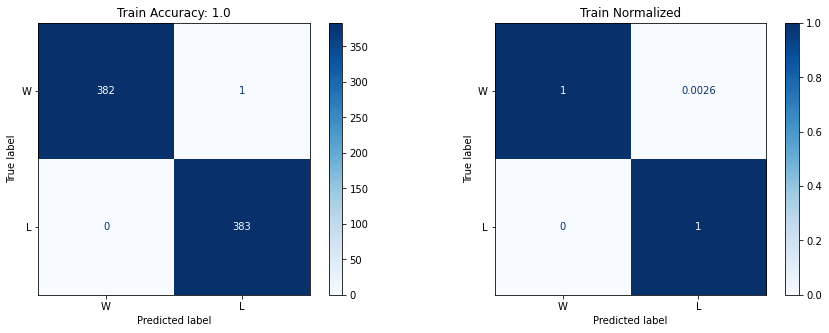

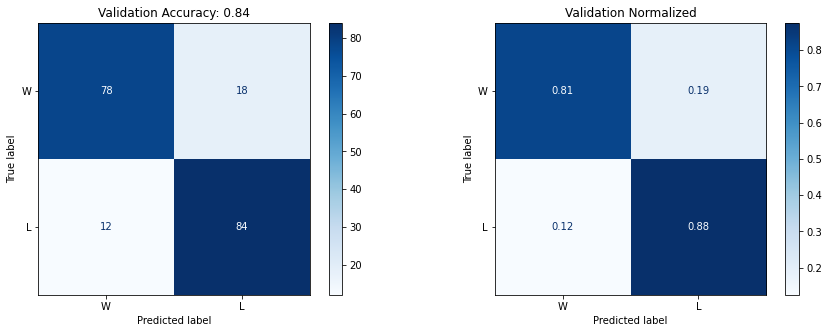

In [19]:
CM(laliga_clf.predict(X_train), y_train, type_ = 'Train', labels = ['W', 'L'], save = 'laliga_train_cm_2.png')
CM(laliga_clf.predict(X_test), y_test, type_ = 'Validation', labels = ['W', 'L'], save = 'laliga_valid_cm_2.png')

In [25]:
r = permutation_importance(laliga_clf, X_test, y_test, n_repeats = 30)

qual_idx = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] > 0:
        qual_idx += [i]
        print("{feat}\t\t{mean} +/- {std}".format(
            feat = X.columns[i],
            mean = np.round(r.importances_mean[i], 3),
            std = np.round(r.importances_std[i], 3)
        ))

away_team_foul_reason_serious_foul		0.03 +/- 0.013
away_team_foul_reason_trip		0.023 +/- 0.009
home_team_card_reason_serious_fouls		0.022 +/- 0.008
away_team_foul_reason_pull		0.013 +/- 0.005
home_team_card_color_y2		0.013 +/- 0.006
home_team_card_reason_advantage		0.005 +/- 0.002


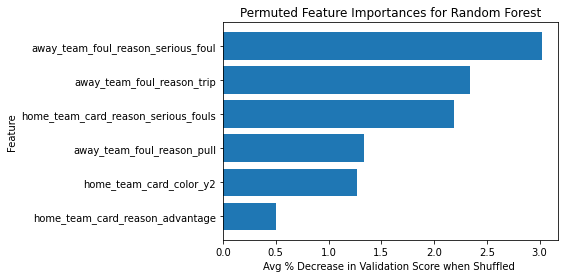

In [27]:
plt.barh(X.columns[qual_idx][::-1], r.importances_mean[qual_idx][::-1]*100)
plt.title('Permuted Feature Importances for Random Forest')
plt.xlabel('Avg % Decrease in Validation Score when Shuffled ')
plt.ylabel('Feature')
#plt.xticks(range(0, 11, 2))
plt.savefig('feat_imp_rf.png', dpi = 200, bbox_inches='tight')
plt.show()

In [28]:
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

In [66]:
a, b = np.where(upper_tri > 0.6)
for w, z in zip(cor_matrix.columns[a], cor_matrix.columns[b]):
    print(w, ' & ', z, np.round(cor_matrix[w][z], 3))

home_team_foul_reason_from_behind  &  away_team_foul_reason_from_behind 0.658
home_team_foul_reason_pushing  &  away_team_foul_reason_pushing 0.619
home_team_foul_reason_trip  &  away_team_foul_reason_trip 0.76
away_team_foul_reason_diving  &  away_team_card_reason_diving 0.63


In [62]:
[cor_matrix[w].loc[z] for w, z in zip(cor_matrix.columns[a], cor_matrix.columns[b])]

[0.65847771997101, 0.6192890832148386, 0.7599111581483454, 0.6295994629557374]

In [67]:
pd.DataFrame({'Feature A' : cor_matrix.columns[a], 'Feature B' : cor_matrix.columns[b], 'Correlation' : [cor_matrix[w].loc[z] for w, z in zip(cor_matrix.columns[a], cor_matrix.columns[b])]})

,Feature A,Feature B,Correlation
0,home_team_foul_reason_from_behind,away_team_foul_reason_from_behind,0.658478
1,home_team_foul_reason_pushing,away_team_foul_reason_pushing,0.619289
2,home_team_foul_reason_trip,away_team_foul_reason_trip,0.759911
3,away_team_foul_reason_diving,away_team_card_reason_diving,0.629599


In [68]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.6)]
to_drop

['away_team_foul_reason_from_behind',
 'away_team_foul_reason_pushing',
 'away_team_foul_reason_trip',
 'away_team_card_reason_diving']

In [37]:
laliga_clf_drop, X_train, X_test, y_train, y_test = train_test(RFpipe, X.drop(to_drop, axis = 1), y, class_labels = ['W', 'L'], weight = True, down_sample = True, return_clf = True)

>>>Preprocess done {'W': 1.0, 'L': 2.077244258872651}
   Class  Accuracy  Precision  Recall   F1  Support
0      W       1.0        1.0     1.0  1.0      383
1      L       1.0        1.0     1.0  1.0      383
2  Total       1.0        1.0     1.0  1.0      766
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.812500   0.804124  0.812500  0.808290       96
1      L  0.802083   0.810526  0.802083  0.806283       96
2  Total  0.807292   0.807325  0.807292  0.807286      192


In [38]:
r = permutation_importance(laliga_clf_drop, X_test, y_test, n_repeats = 30)

qual_idx = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] > 0:
        qual_idx += [i]
        print("{feat}\t\t{mean} +/- {std}".format(
            feat = X.columns[i],
            mean = np.round(r.importances_mean[i], 3),
            std = np.round(r.importances_std[i], 3)
        ))

home_team_foul_reason_obstruction		0.034 +/- 0.009
away_team_card_reason_violence		0.014 +/- 0.005
home_team_foul_reason_serious_foul		0.01 +/- 0.005
away_team_card_reason_Unsportsmanlike Cond		0.009 +/- 0.004
home_team_card_reason_emergency_brake		0.008 +/- 0.004
away_team_card_reason_verbal_abuse		0.005 +/- 0.001
home_team_foul_reason_pull		0.005 +/- 0.0


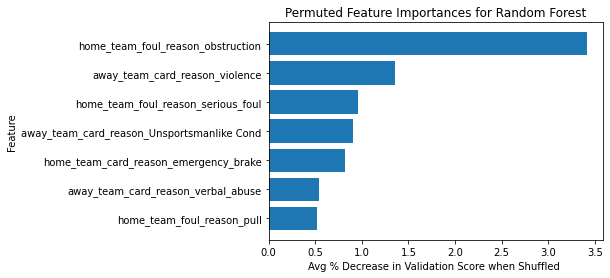

In [39]:
plt.barh(X.columns[qual_idx][::-1], r.importances_mean[qual_idx][::-1]*100)
plt.title('Permuted Feature Importances for Random Forest')
plt.xlabel('Avg % Decrease in Validation Score when Shuffled ')
plt.ylabel('Feature')
#plt.xticks(range(0, 11, 2))
#plt.savefig('feat_imp_rf.png', dpi = 200, bbox_inches='tight')
plt.show()

In [46]:
X.filter(regex = 'card_reason').shape[1]/2

13.0

In [48]:
X.shape

(1618, 58)

In [70]:
data_all = pd.read_csv('~/Downloads/archive/understat_per_game.csv')

In [73]:
data_all[data_all['league'] == 'EPL']

,league,year,h_a,xG,xGA,npxG,npxGA,deep,deep_allowed,scored,...,ppda_coef,ppda_att,ppda_def,oppda_coef,oppda_att,oppda_def,team,xG_diff,xGA_diff,xpts_diff
3672,EPL,2014,a,0.909774,0.423368,0.909774,0.423368,4,3,1,...,14.043478,323,23,4.125000,132,32,Aston Villa,-0.090226,0.423368,-1.1678
3673,EPL,2014,h,0.507525,0.699295,0.507525,0.699295,4,7,0,...,15.523810,326,21,8.571429,180,21,Aston Villa,0.507525,0.699295,0.1057
3674,EPL,2014,h,0.639316,0.288880,0.639316,0.288880,6,7,2,...,28.153846,366,13,11.583333,278,24,Aston Villa,-1.360684,-0.711120,-1.3925
3675,EPL,2014,a,0.701676,0.728097,0.701676,0.728097,1,5,1,...,54.000000,486,9,6.500000,91,14,Aston Villa,-0.298324,0.728097,-1.6748
3676,EPL,2014,h,0.649013,1.362240,0.649013,1.362240,0,7,0,...,44.250000,531,12,7.727273,170,22,Aston Villa,0.649013,-1.637760,0.6912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8227,EPL,2019,h,0.470483,0.326909,0.470483,0.326909,7,2,1,...,18.888889,340,18,11.846154,154,13,Sheffield United,-0.529517,0.326909,-1.5949
8228,EPL,2019,h,2.006320,1.175090,2.006320,1.175090,5,3,3,...,45.909091,505,11,4.733333,71,15,Sheffield United,-0.993680,1.175090,-0.9566
8229,EPL,2019,a,0.660214,3.057520,0.660214,3.057520,1,6,0,...,10.173913,234,23,9.250000,185,20,Sheffield United,0.660214,1.057520,0.1466
8230,EPL,2019,h,0.468461,0.624814,0.468461,0.624814,5,3,0,...,11.400000,285,25,13.062500,209,16,Sheffield United,0.468461,-0.375186,1.0608


In [84]:
data_all[data_all['league'] == 'EPL'][['league', 'date', 'team', 'xG', 'result']]

,league,date,team,xG,result
3672,EPL,2014-08-16 15:00:00,Aston Villa,0.909774,w
3673,EPL,2014-08-23 12:45:00,Aston Villa,0.507525,d
3674,EPL,2014-08-31 13:30:00,Aston Villa,0.639316,w
3675,EPL,2014-09-13 17:30:00,Aston Villa,0.701676,w
3676,EPL,2014-09-20 15:00:00,Aston Villa,0.649013,l
...,...,...,...,...,...
8227,EPL,2020-07-08 17:00:00,Sheffield United,0.470483,w
8228,EPL,2020-07-11 16:30:00,Sheffield United,2.006320,w
8229,EPL,2020-07-16 17:00:00,Sheffield United,0.660214,l
8230,EPL,2020-07-20 17:00:00,Sheffield United,0.468461,l


In [87]:
epl = pd.read_csv('~/Downloads/season-0910_csv.csv')
epl.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA
0,E0,2009-08-15,Aston Villa,Wigan,0,2,A,0,1,A,...,2.04,1.92,1.91,1.81,21,0.0,1.28,1.22,4.40,3.99
1,E0,2009-08-15,Blackburn,Man City,0,2,A,0,1,A,...,2.15,2.04,1.78,1.71,24,0.0,2.58,2.38,1.60,1.54
2,E0,2009-08-15,Bolton,Sunderland,0,1,A,0,1,A,...,2.25,2.12,1.70,1.66,23,0.0,1.68,1.61,2.33,2.23
3,E0,2009-08-15,Chelsea,Hull,2,1,H,1,1,D,...,1.67,1.58,2.44,2.26,22,0.0,1.03,1.02,17.05,12.96
4,E0,2009-08-15,Everton,Arsenal,1,6,A,0,3,A,...,2.20,2.06,1.77,1.70,24,0.0,2.27,2.20,1.73,1.63


In [133]:
#epl['Referee']
short_09 = epl[['Date', 'HomeTeam', 'AwayTeam', 'Referee']].copy()
short_09['Date'] = short_09['Date'].astype(np.datetime64)
short_09.head()

,Date,HomeTeam,AwayTeam,Referee
0,2009-08-15,Aston Villa,Wigan,M Clattenburg
1,2009-08-15,Blackburn,Man City,M Dean
2,2009-08-15,Bolton,Sunderland,A Marriner
3,2009-08-15,Chelsea,Hull,A Wiley
4,2009-08-15,Everton,Arsenal,M Halsey


In [166]:
ref_df = pd.merge(epl_data, short_09, how = 'inner', left_on = ['date'], right_on = ['Date'])
ref_df['home_team_name'] = ref_df['home_team_name'].replace(' City', '').replace('Wolverhampton Wanderers', 'Wolves')
ref_df.shape

(1856, 74)

In [174]:
#epl_data['home_team_name'].unique()
ref_df[ref_df.apply(lambda x: x['HomeTeam'] in x['home_team_name'], axis = 1)].drop(['Date', 'HomeTeam', 'AwayTeam'], axis = 1)

,match_api_id,league_id,date,home_team_api_id,home_team_name,away_team_api_id,away_team_name,home_team_goal,away_team_goal,home_team_foul_reason_from_behind,...,home_team_card_reason_diving,away_team_card_reason_diving,home_team_card_reason_hands,away_team_card_reason_hands,home_team_card_reason_Removing Shirt,away_team_card_reason_Removing Shirt,result,home_elo,away_elo,Referee
3,658582,1729,2009-08-15,8455,Chelsea,8667,Hull City,2,4,2.0,...,0.0,0.0,0.0,0.0,2.0,0.0,L,1697.133,1520.841,A Wiley
13,658580,1729,2009-08-15,8462,Portsmouth,9879,Fulham,0,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,L,1531.890,1611.769,M Atkinson
22,658581,1729,2009-08-15,10194,Stoke City,8191,Burnley,2,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,W,1582.561,1600.000,S Bennett
24,658575,1729,2009-08-15,10252,Aston Villa,8528,Wigan Athletic,0,8,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,L,1605.377,1584.165,M Clattenburg
34,658579,1729,2009-08-15,8559,Bolton Wanderers,8472,Sunderland,0,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,L,1519.271,1518.518,A Marriner
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1806,659375,1729,2010-05-09,9825,Arsenal,9879,Fulham,4,0,6.0,...,2.0,0.0,2.0,0.0,0.0,0.0,W,1758.921,1590.277,M Jones
1817,659374,1729,2010-05-09,10252,Aston Villa,8655,Blackburn Rovers,0,4,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,L,1677.511,1569.382,S Bennett
1828,659373,1729,2010-05-09,8559,Bolton Wanderers,8658,Birmingham City,2,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,L,1498.005,1582.191,K Friend
1840,659371,1729,2010-05-09,8455,Chelsea,8528,Wigan Athletic,8,0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,W,1816.836,1554.799,M Atkinson


In [168]:
short_09.shape

(380, 4)

In [177]:
epl_data['date'].max()

Timestamp('2016-05-17 00:00:00')